This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Plot geodata with cartopy 

- **underlay** e.g. terrain data from a Digital Elevation Model (DEM)
- **overlay** features such as administrative borders, rivers, catchments, rain gauges, cities, ...

*Here, we create a map without radar data to concentrate on the other layers.*

In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

# Some more matplotlib tools we will need...
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Plotting a Digital Elevation Model (DEM)

We use a preprocessed geotiff which was created from [**SRTM**](https://www2.jpl.nasa.gov/srtm/index.html) data via `gdal`

```bash
gdalwarp -te 88. 20. 93. 27. srtm_54_07.tif srtm_55_07.tif srtm_54_08.tif srtm_55_08.tif bangladesh.tif
```

Here we
- read the DEM via [wradlib.io.open_raster](https://docs.wradlib.org/en/latest/generated/wradlib.io.gdal.open_raster.html) and extracted via [wradlib.georef.extract_raster_dataset](https://docs.wradlib.org/en/latest/generated/wradlib.georef.raster.extract_raster_dataset.html).
- resample the data to a (lon/lat) grid with `spacing=0.005`.

*Note: we organise the code in functions which we can re-use in this notebook.*

In [2]:
def plot_dem(ax):
    filename = wrl.util.get_wradlib_data_file("geo/bangladesh.tif")
    ds = wrl.io.open_raster(filename)
    # pixel_spacing is in output units (lonlat)
    ds = wrl.georef.reproject_raster_dataset(ds, spacing=0.005)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds)
    # specify kwargs for plotting, using terrain colormap and LogNorm
    dem = ax.pcolormesh(
        rastercoords[..., 0],
        rastercoords[..., 1],
        rastervalues,
        cmap=plt.cm.terrain,
        norm=LogNorm(vmin=1, vmax=3000),
        transform=ccrs.PlateCarree(),
    )
    # add colorbar and title
    # we use LogLocator for colorbar
    cb = plt.gcf().colorbar(dem, ticks=ticker.LogLocator(subs=range(10)), pad=0.075)
    cb.set_label("terrain height [m]")

In [3]:
map_proj = ccrs.Mercator(central_longitude=90.5)

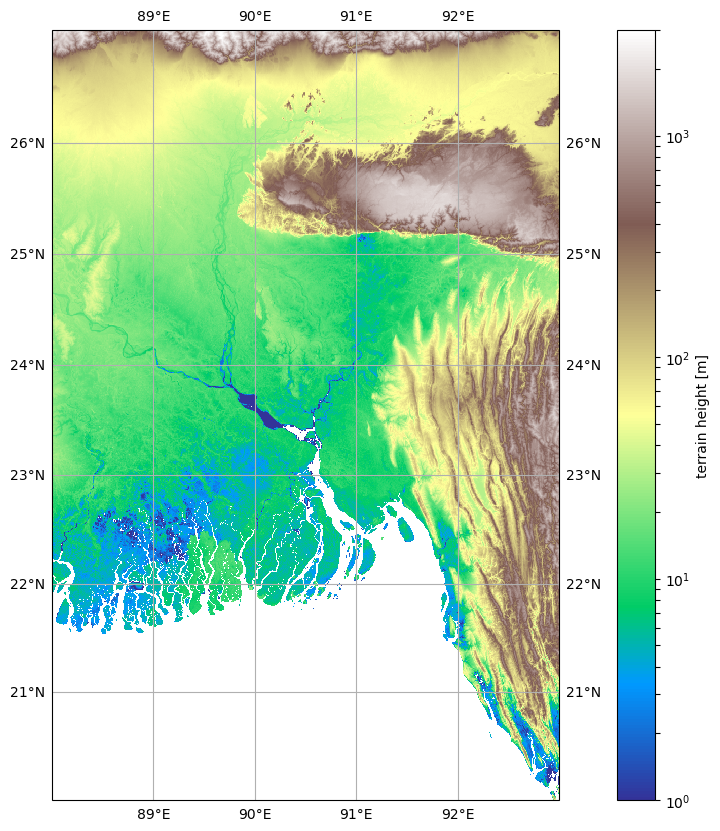

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=map_proj)
plot_dem(ax)
ax.gridlines(draw_labels=True)

## Plotting borders

For country borders, we use [ESRI Shapfiles](https://de.wikipedia.org/wiki/Shapefile) from [Natural Earth Data](https://www.naturalearthdata.com/). 

We extract features using 
- the `OGR.Layer` `AttributeFilter` and 
- the [wradlib.georef.get_vector_coordinates](https://docs.wradlib.org/en/latest/generated/wradlib.georef.vector.get_vector_coordinates.html) function. 

The plot overlay is done via [wradlib.vis.add_lines](https://docs.wradlib.org/en/latest/generated/wradlib.vis.add_lines.html).

In [5]:
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="10m",
        facecolor="none",
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)

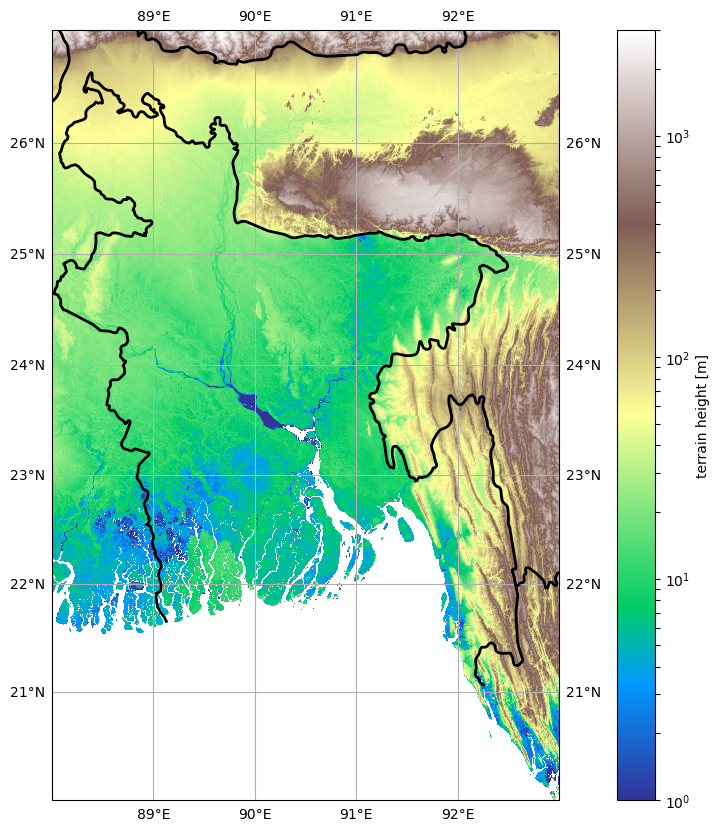

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=map_proj)
plot_dem(ax)
plot_borders(ax)
ax.set_extent([88, 93, 20, 27], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)

## Plotting Rivers

For rivers, we use [ESRI Shapfiles](https://de.wikipedia.org/wiki/Shapefile) from [FAO](https://data.apps.fao.org/map/catalog/srv/eng/catalog.search#/metadata/dc2a5121-0b32-482b-bd9b-64f7a414fa0d) and [Natural Earth Data](https://www.naturalearthdata.com/). 

We extract features using 
- the `OGR.Layer` `SpatialFilter` and 
- the [wradlib.georef.get_vector_coordinates](https://docs.wradlib.org/en/latest/generated/wradlib.georef.vector.get_vector_coordinates.html) function.

Then we use [wradlib.vis.add_lines](https://docs.wradlib.org/en/latest/generated/wradlib.vis.add_lines.html) again for the overlay.

In [7]:
flist = [
    "geo/rivers_asia_37331.shx",
    "geo/rivers_asia_37331.prj",
    "geo/rivers_asia_37331.dbf",
]
[wrl.util.get_wradlib_data_file(f) for f in flist]


def plot_rivers(ax):
    # plot rivers from esri vector shape, filter spatially
    # http://www.fao.org/geonetwork/srv/en/metadata.show?id=37331

    # open the input data source and get the layer
    filename = wrl.util.get_wradlib_data_file("geo/rivers_asia_37331.shp")
    dataset, inLayer = wrl.io.open_vector(filename)

    # do spatial filtering to get only geometries inside bounding box
    inLayer.SetSpatialFilterRect(88, 20, 93, 27)
    rivers, keys = wrl.georef.get_vector_coordinates(inLayer, key="MAJ_NAME")

    # plot on ax1, and ax4
    wrl.vis.add_lines(
        ax,
        rivers,
        color=plt.cm.terrain(0.0),
        lw=0.5,
        zorder=3,
        transform=ccrs.PlateCarree(),
    )

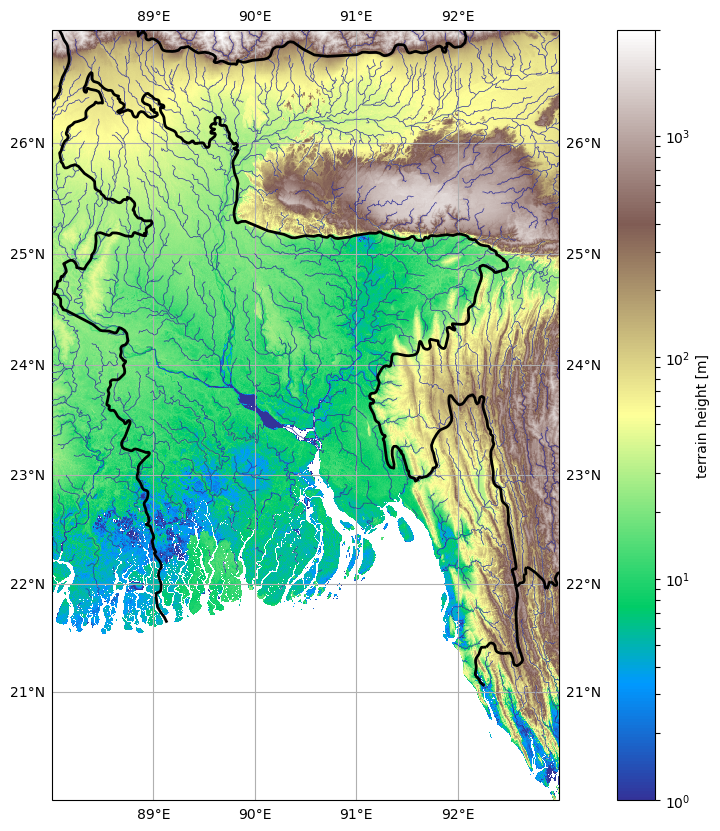

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=map_proj)
plot_dem(ax)
plot_borders(ax)
plot_rivers(ax)
ax.set_extent([88, 93, 20, 27], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)

In [9]:
flist = [
    "geo/ne_10m_rivers_lake_centerlines.shx",
    "geo/ne_10m_rivers_lake_centerlines.prj",
    "geo/ne_10m_rivers_lake_centerlines.dbf",
]
[wrl.util.get_wradlib_data_file(f) for f in flist]


def plot_water(ax):
    # plot rivers from esri vector shape, filter spatially
    # plot rivers from NED
    # open the input data source and get the layer
    filename = wrl.util.get_wradlib_data_file("geo/ne_10m_rivers_lake_centerlines.shp")
    dataset, inLayer = wrl.io.open_vector(filename)
    inLayer.SetSpatialFilterRect(88, 20, 93, 27)
    rivers, keys = wrl.georef.get_vector_coordinates(inLayer)
    wrl.vis.add_lines(
        ax,
        rivers,
        color=plt.cm.terrain(0.0),
        lw=0.5,
        zorder=3,
        transform=ccrs.PlateCarree(),
    )

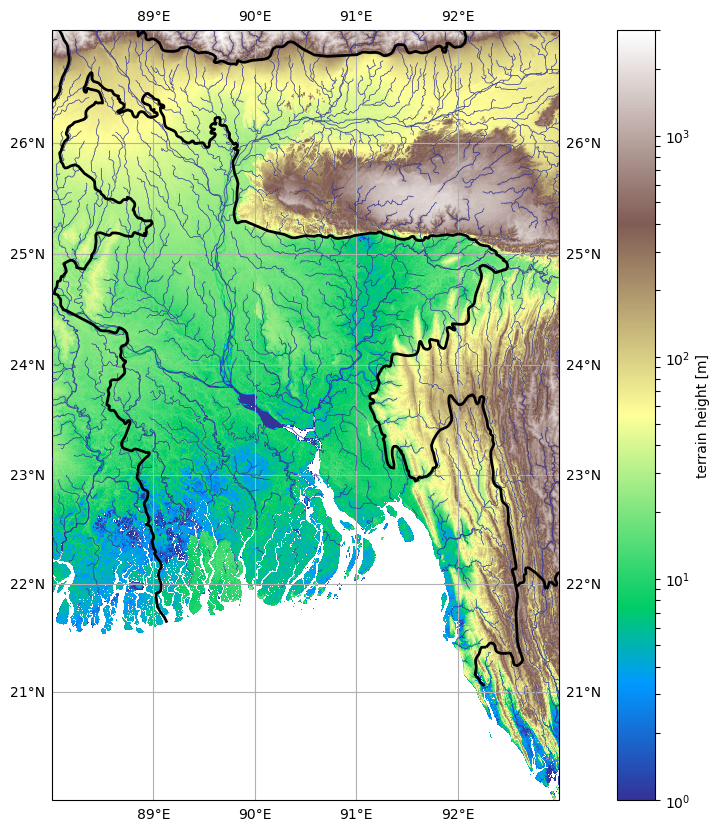

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=map_proj)
plot_dem(ax)
plot_borders(ax)
plot_rivers(ax)
plot_water(ax)
ax.set_extent([88, 93, 20, 27], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)

## Plotting Cities

The 5 biggest cities of bangladesh are added using simple matplotlib functions.

In [11]:
def plot_cities(ax):
    # plot city dots with annotation, finalize plot
    # lat/lon coordinates of five cities in Bangladesh
    lats = [23.73, 22.32, 22.83, 24.37, 24.90]
    lons = [90.40, 91.82, 89.55, 88.60, 91.87]
    cities = ["Dhaka", "Chittagong", "Khulna", "Rajshahi", "Sylhet"]
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, "ro", zorder=5, transform=ccrs.PlateCarree())
        ax.text(
            lon + 0.01, lat + 0.01, city, fontsize="large", transform=ccrs.PlateCarree()
        )

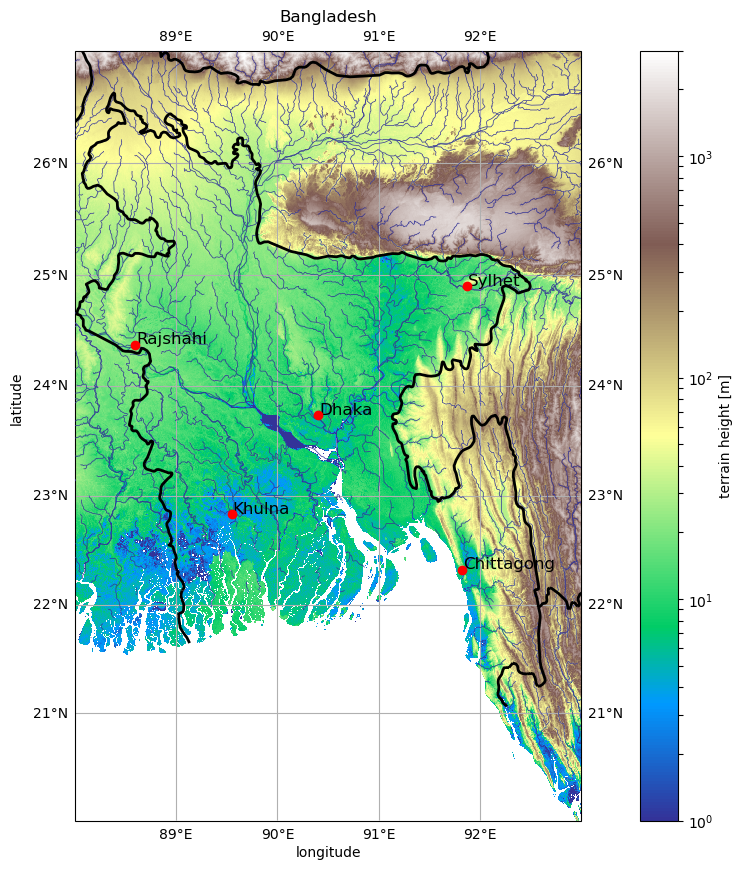

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=map_proj)
plot_dem(ax)
plot_borders(ax)
plot_rivers(ax)
plot_water(ax)
plot_cities(ax)

ax.set_extent([88, 93, 20, 27], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.text(
    -0.1,
    0.55,
    "latitude",
    va="bottom",
    ha="center",
    rotation="vertical",
    rotation_mode="anchor",
    transform=ax.transAxes,
)
ax.text(
    0.5,
    -0.05,
    "longitude",
    va="bottom",
    ha="center",
    rotation="horizontal",
    rotation_mode="anchor",
    transform=ax.transAxes,
)
t = ax.set_title("Bangladesh")
t.set_y(1.05)

## Plotting country patches

### Plotting in "geographic projection" (WGS84)

Here, we plot countries as `patches` on a lat/lon (WGS84) map (data from [Natural Earth Data](https://www.naturalearthdata.com/) again).

We again extract the features using 
- the `OGR.Layer` `SpatialFilter` and 
- [wradlib.georef.get_vector_coordinates](https://docs.wradlib.org/en/latest/generated/wradlib.georef.vector.get_vector_coordinates.html).

Then the patches are added one by one via [wradlib.vis.add_patches](https://docs.wradlib.org/en/latest/generated/wradlib.vis.add_patches.html).

In [13]:
flist = [
    "geo/ne_10m_admin_0_countries.shx",
    "geo/ne_10m_admin_0_countries.prj",
    "geo/ne_10m_admin_0_countries.dbf",
]
[wrl.util.get_wradlib_data_file(f) for f in flist]


def plot_wgs84(ax):
    from osgeo import osr

    wgs84 = osr.SpatialReference()
    wgs84.ImportFromEPSG(4326)
    # some testing on additional axes
    # add Bangladesh to countries
    countries = ["India", "Nepal", "Bhutan", "Myanmar", "Bangladesh"]
    # create colors for country-patches
    cm = plt.cm.jet
    colors = []
    for i in range(len(countries)):
        colors.append(cm(1.0 * i / len(countries)))

    # open the input data source and get the layer
    filename = wrl.util.get_wradlib_data_file("geo/ne_10m_admin_0_countries.shp")
    dataset, layer = wrl.io.open_vector(filename)

    # filter spatially and plot as PatchCollection on ax3
    layer.SetSpatialFilterRect(88, 20, 93, 27)
    patches, keys = wrl.georef.get_vector_coordinates(layer, dest_srs=wgs84, key="name")
    i = 0
    for name, patch in zip(keys, patches):
        # why comes the US in here?
        if name in countries:
            wrl.vis.add_patches(
                ax,
                patch,
                facecolor=colors[i],
                cmap=plt.cm.viridis,
                alpha=0.4,
                transform=ccrs.PlateCarree(),
            )
            i += 1
    ax.autoscale(True)
    # ax.set_aspect('equal')
    # ax.set_xlabel('Longitude')
    # ax.set_ylabel('Latitude')
    ax.set_extent([66, 102, 5, 37], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True)
    ax.text(
        -0.07,
        0.55,
        "latitude",
        va="bottom",
        ha="center",
        rotation="vertical",
        rotation_mode="anchor",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.075,
        "longitude",
        va="bottom",
        ha="center",
        rotation="horizontal",
        rotation_mode="anchor",
        transform=ax.transAxes,
    )
    t = ax.set_title("South Asia - PlateCarree()")
    t.set_y(1.05)

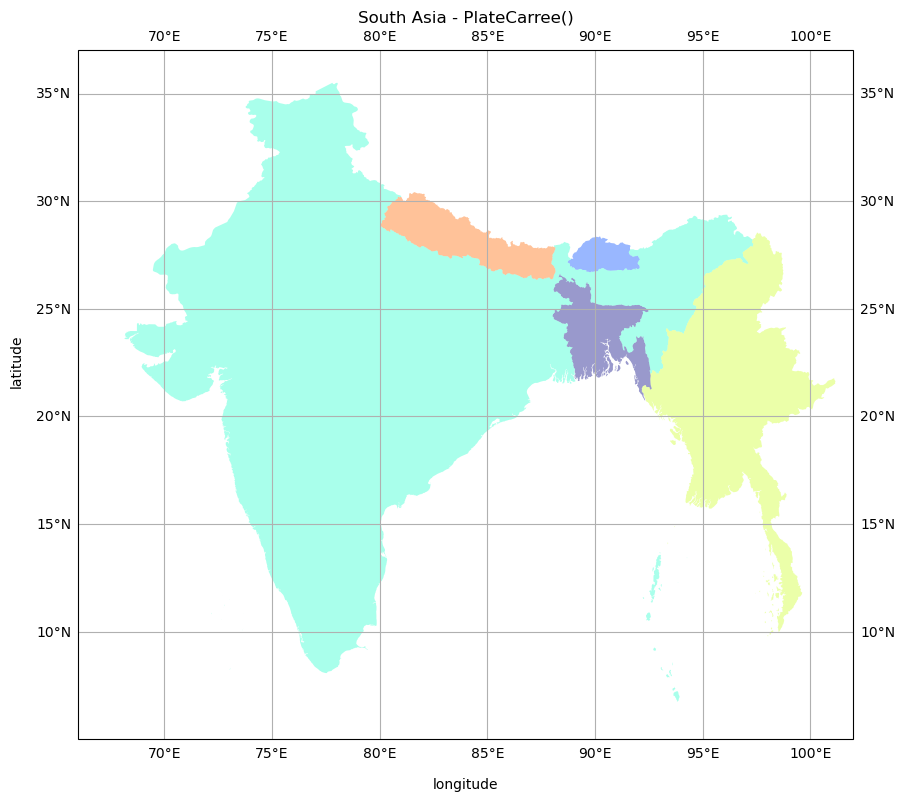

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
plot_wgs84(ax)

### Plotting with a map projection

Here, we plot countries as patches on a projected map.  

We extract the features using 
- the `OGR.Layer` `AttributeFilter` and
- the [wradlib.georef.get_vector_coordinates](https://docs.wradlib.org/en/latest/generated/wradlib.georef.vector.get_vector_coordinates.html) function. 

The coordinates of the features are reprojected on the fly using the `dest_srs` keyword of [wradlib.georef.get_vector_coordinates](https://docs.wradlib.org/en/latest/generated/wradlib.georef.vector.get_vector_coordinates.html).

Then, the patches are added to the map via [wradlib.vis.add_patches](https://docs.wradlib.org/en/latest/generated/wradlib.vis.add_patches.html).

In [15]:
def plot_lambert(ax):
    # add Bangladesh to countries
    countries = ["India", "Nepal", "Bhutan", "Myanmar", "Bangladesh"]
    # create colors for country-patches
    cm = plt.cm.jet
    colors = []
    for i in range(len(countries)):
        colors.append(cm(1.0 * i / len(countries)))

    # open the input data source and get the layer
    filename = wrl.util.get_wradlib_data_file("geo/ne_10m_admin_0_countries.shp")
    dataset, layer = wrl.io.open_vector(filename)
    # iterate over countries, filter by attribute,
    # plot single patches on ax2
    for i, item in enumerate(countries):
        fattr = "name = '" + item + "'"
        layer.SetAttributeFilter(fattr)
        # get country patches
        patches, keys = wrl.georef.get_vector_coordinates(layer, key="name")
        wrl.vis.add_patches(
            plt.gca(), patches, facecolor=colors[i], transform=ccrs.PlateCarree()
        )

    ax.set_extent([66, 102, 5, 37], crs=ccrs.PlateCarree())
    ax.gridlines()
    ax.text(
        -0.07,
        0.55,
        "latitude",
        va="bottom",
        ha="center",
        rotation="vertical",
        rotation_mode="anchor",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.075,
        "longitude",
        va="bottom",
        ha="center",
        rotation="horizontal",
        rotation_mode="anchor",
        transform=ax.transAxes,
    )
    t = ax.set_title("South Asia in LambertAzimuthalEqualArea")
    t.set_y(1.05)

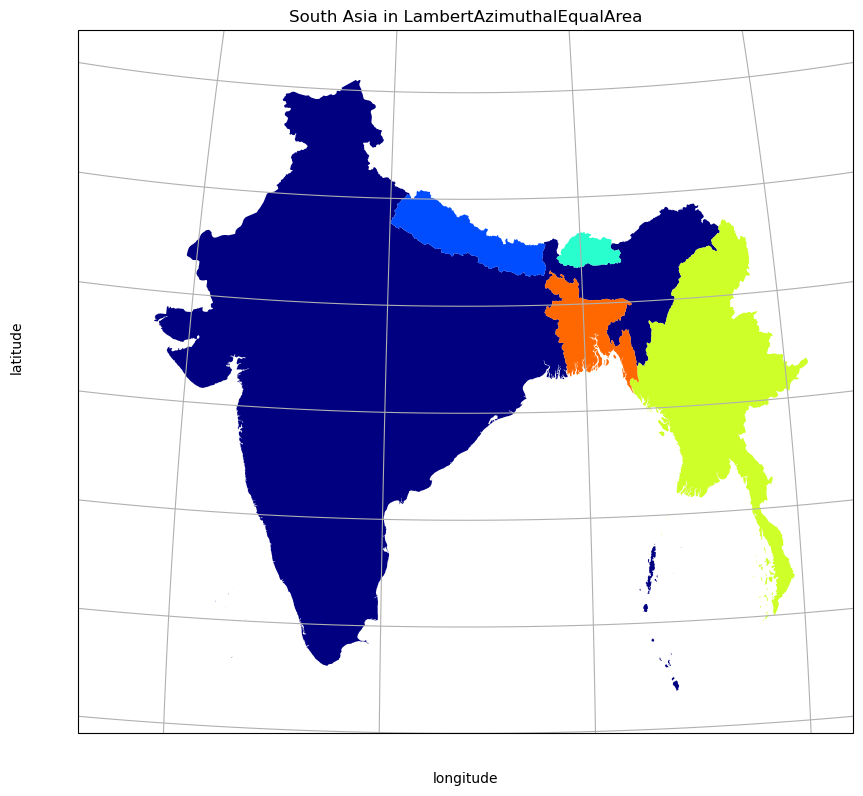

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(
    111,
    projection=ccrs.LambertAzimuthalEqualArea(
        central_longitude=84, central_latitude=20
    ),
)
plot_lambert(ax)